In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Reshape
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing import image
from keras.utils import load_img, img_to_array
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from IPython.display import Image
import itertools
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.chdir('../../data')

2022-10-06 08:35:34.241832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-06 08:35:34.241883: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-06 08:35:34.328313: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-06 08:35:36.028372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-06 08:35:36.028535: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

In [2]:
# !git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

In [3]:
mobileNet = tf.keras.applications.mobilenet.MobileNet()

2022-10-06 08:35:39.824550: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-10-06 08:35:39.824646: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sheded-Latitude-E6520): /proc/driver/nvidia/version does not exist


In [4]:
def prepare_image(img_name):
    img_path = '/home/sheded/DataspellProjects/computer vision/data/mobileNet/'
    img = load_img(img_path+img_name, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

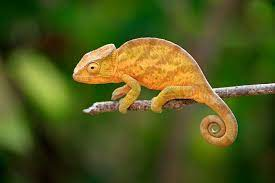

In [5]:
Image(filename='mobileNet/hr.jpg', width=450, height=300)

In [6]:
preprocessed_image = prepare_image('hr.jpg')
predictions = mobileNet.predict(preprocessed_image)

1/1 [==============================] - 1s 1s/step


In [7]:
results = imagenet_utils.decode_predictions(predictions)

In [8]:
results

[[('n01694178', 'African_chameleon', 0.99809724),
  ('n01675722', 'banded_gecko', 0.0018332386),
  ('n01630670', 'common_newt', 2.9890416e-05),
  ('n01644900', 'tailed_frog', 1.6897622e-05),
  ('n01685808', 'whiptail', 1.0182522e-05)]]

### Organize data into train, valid, test dirs

In [9]:
os.chdir('mobileNet/Sign-Language-Digits-Dataset-master/Dataset')
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../../..')

In [10]:
train_path = r'mobileNet/Sign-Language-Digits-Dataset-master/Dataset/train'
valid_path = r'mobileNet/Sign-Language-Digits-Dataset-master/Dataset/valid'
test_path = r'mobileNet/Sign-Language-Digits-Dataset-master/Dataset/test'

train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224, 224), batch_size=10
)

valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224, 224), batch_size=10
)

test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224, 224), batch_size=10, shuffle=False
)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [11]:
mobileNet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [12]:
x = mobileNet.layers[-5].output
x

<KerasTensor: shape=(None, 1, 1, 1024) dtype=float32 (created by layer 'global_average_pooling2d')>

In [13]:
reshape = Reshape((1024,))(x)
output = Dense(10, activation='softmax')(reshape)

In [14]:
model = Model(inputs=mobileNet.input, outputs=output)

In [15]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [17]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(x=train_batches, steps_per_epoch=len(train_batches), validation_data=valid_batches, validation_steps=len(valid_batches),
                    epochs=6, verbose=1)

Epoch 1/6
172/172 [==============================] - 214s 1s/step - loss: 0.4012 - accuracy: 0.8715 - val_loss: 1.0425 - val_accuracy: 0.6500
Epoch 2/6
172/172 [==============================] - 198s 1s/step - loss: 0.0866 - accuracy: 0.9743 - val_loss: 0.6209 - val_accuracy: 0.8600
Epoch 3/6
172/172 [==============================] - 199s 1s/step - loss: 0.0953 - accuracy: 0.9737 - val_loss: 0.2644 - val_accuracy: 0.8933
Epoch 4/6
172/172 [==============================] - 201s 1s/step - loss: 0.0501 - accuracy: 0.9801 - val_loss: 0.1676 - val_accuracy: 0.9500
Epoch 5/6
172/172 [==============================] - 203s 1s/step - loss: 0.0233 - accuracy: 0.9912 - val_loss: 0.0339 - val_accuracy: 0.9900
Epoch 6/6
172/172 [==============================] - 200s 1s/step - loss: 0.0263 - accuracy: 0.9918 - val_loss: 0.0116 - val_accuracy: 0.9933


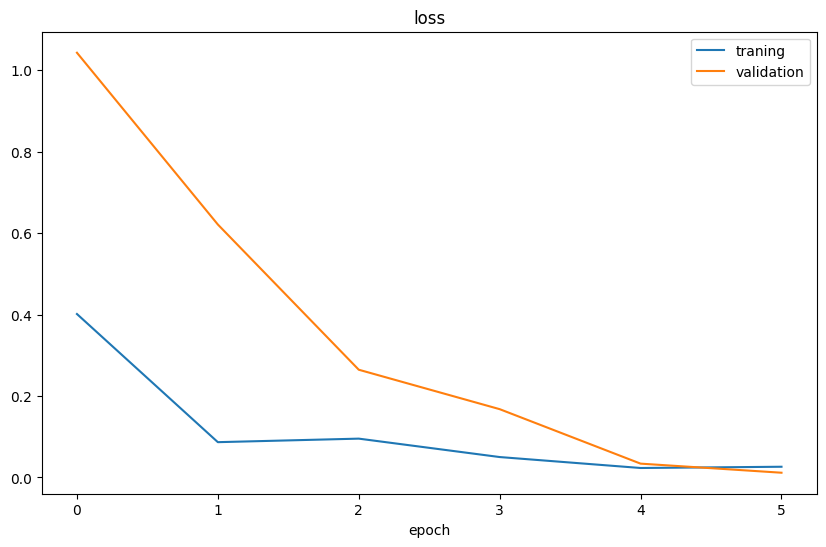

In [25]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['traning', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.show()

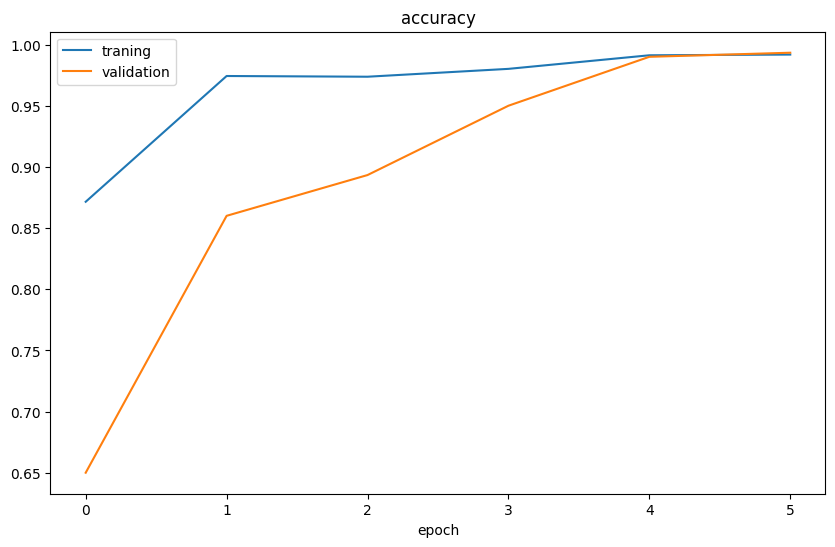

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['traning', 'validation'])
plt.title('accuracy')
plt.xlabel('epoch')
plt.show()

In [19]:
test_labels = test_batches.classes
test_labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8, 9, 9, 9, 9, 9], dtype=int32)

In [20]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [21]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
cm

array([[5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 5, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 5, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 5, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 5, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 5, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 5, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 5, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]])

In [22]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

In [23]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

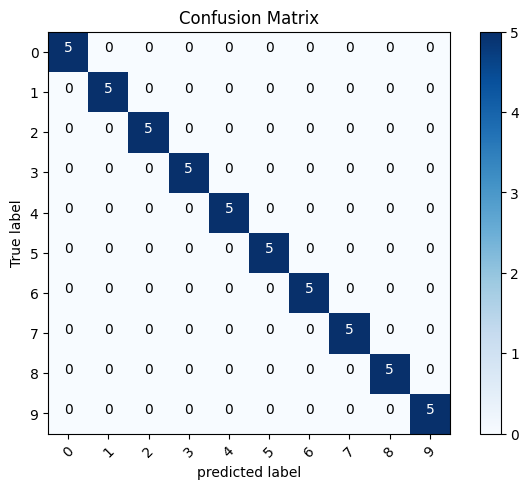

In [24]:
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [27]:
model.save('mobileNet/modelv1.h5')